In [5]:
EMBED_MODEL = 'nomic-embed-text'
LANG_MODEL = 'gemma3:4b'
SUMMARISE_MODEL = 'gemma3:1b'
LIB_ROOT = 'library'
VECTOR_CACHE_ROOT = 'cache'

In [19]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.document_loaders import PDFPlumberLoader, CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_experimental.text_splitter import SemanticChunker
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage

from langgraph.checkpoint.memory import MemorySaver
from unstructured.partition.pdf import partition_pdf
from langchain_ollama import ChatOllama, OllamaLLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from langchain_core.messages import AIMessageChunk
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document

import os

embedder = OllamaEmbeddings(model=EMBED_MODEL)
text_splitter = SemanticChunker(embedder)
model = ChatOllama(model=LANG_MODEL, num_ctx=8192)
summarizer = OllamaLLM(model=SUMMARISE_MODEL)

if not os.path.exists(VECTOR_CACHE_ROOT):
    os.mkdir(VECTOR_CACHE_ROOT)


def md5(filename):
    import hashlib
    import codecs
    return hashlib.md5(codecs.encode(filename)).hexdigest()

def gen_text_and_table_summaries(path):
    """
    从 PDF 中提取文本和表格, 使用大模型总结
    """
    # Extract elements from PDF
    def extract_pdf_elements(path):
        """
        Extract images, tables, and chunk text from a PDF file.
        path: File path, which is used to dump images (.jpg)
        fname: File name
        """
        return partition_pdf(
            filename=path,
            extract_images_in_pdf=False,
            infer_table_structure=True,
            chunking_strategy="by_title",
            max_characters=4000,
            new_after_n_chars=3800,
            combine_text_under_n_chars=2000,
            image_output_dir_path=path,
            )


    # Categorize elements by type
    def categorize_elements(raw_pdf_elements):
        """
        Categorize extracted elements from a PDF into tables and texts.
        raw_pdf_elements: List of unstructured.documents.elements
        """
        tables = []
        texts = []
        for element in raw_pdf_elements:
            if "unstructured.documents.elements.Table" in str(type(element)):
                tables.append(str(element))
            elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
                texts.append(str(element))
        return texts, tables
    
    def generate_text_summaries(texts, tables, summarize_texts=False):
        """
        Summarize text elements
        texts: List of str
        tables: List of str
        summarize_texts: Bool to summarize texts
        """

        # Prompt
        prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
        These summaries will be embedded and used to retrieve the raw text or table elements. \
        Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
        prompt = ChatPromptTemplate.from_template(prompt_text)

        # Text summary chain
        summarize_chain = {"element": lambda x: x} | prompt | summarizer | StrOutputParser()

        # Initialize empty summaries
        text_summaries = []
        table_summaries = []

        # Apply to text if texts are provided and summarization is requested
        if texts and summarize_texts:
            text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
        elif texts:
            text_summaries = texts

        # Apply to tables if tables are provided
        if tables:
            table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

        return text_summaries, table_summaries
    raw = extract_pdf_elements(path)
    texts, tables = categorize_elements(raw)
    texts, tables = text_splitter.split_text(" ".join(texts)), tables
    return (texts, tables), generate_text_summaries(texts, tables, True)

def get_img_summaries(image_path) -> tuple[list[str], list[str]]:
    import base64
    """
    summaries all images under dir
    """
    def encode_image(path):
        with open(path, 'rb') as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    
    def image_summarize(img_base64, prompt):
        """Make image summary"""

        msg = summarizer.invoke(
            [
                HumanMessage(
                    content=[
                        {"type": "text", "text": prompt},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                        },
                    ]
                )
            ]
        )
        return msg
        # Store base64 encoded images

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""
    # Apply to images
    base64_image = encode_image(image_path)


    return base64_image, image_summarize(base64_image, prompt)

def to_doc(path: str):
    """
    把给定文件转换成文档格式，主要是一个加载和分段的过程.
    适用于简单 RAG
    """
    from typing import List
    from pydantic import TypeAdapter
    adapter = TypeAdapter(List[Document])
    ret: 'list[Document]'
    cache_file = os.path.join(VECTOR_CACHE_ROOT, md5(path))
    # 分段的过程比较慢（取决于 embedding 实现），因此我们用文件进行缓存
    if os.path.exists(cache_file):
        print(f'cache for {path} exists, will use cache')
        with open(cache_file, 'rb') as c:
            content = c.read()
            return adapter.validate_json(content)
    loader = None
    if path.endswith('pdf'):
        loader = PDFPlumberLoader(path)
    if path.endswith('csv'):
        loader = CSVLoader(path, encoding='utf-8')
    print(f'loading doc {path}')
    docs = loader.load()
    print(f'spliting {path}')
    ret = text_splitter.split_documents(docs)

    with open(cache_file, 'wb') as f:
        f.write(adapter.dump_json(ret))
    return ret

def build_vector_store():
    """
    把所有 library 目录下的文档一起构建一个向量数据库
    """
    docfiles = []
    for file in os.listdir(LIB_ROOT):
        docfiles.append(os.path.join(LIB_ROOT, file))
    
    docs = map(to_doc, docfiles)
    documents = [d for ds in docs if ds is not None for d in ds]
    print('building vector store')
    vector = FAISS.from_documents(documents, embedder)

    return vector


def build_multi_modal_vector_store():
    import uuid
    store = InMemoryStore()
    id_key = "doc_id"
    # Create the multi-vector retriever
    # The vectorstore to use to index the summaries
    vectorstore = Chroma(
        collection_name="mm_rag_cj_blog", embedding_function=embedder
    )
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )
    def add_documents(retriever, doc_summaries, doc_contents):
            doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
            summary_docs = [
                Document(page_content=s, metadata={id_key: doc_ids[i]})
                for i, s in enumerate(doc_summaries)
            ]
            retriever.vectorstore.add_documents(summary_docs)
            retriever.docstore.mset(list(zip(doc_ids, doc_contents)))
    
    for file in os.listdir(LIB_ROOT):
        if file.endswith('pdf'):
            (texts, tables ), (text_summaries, table_summaries) = gen_text_and_table_summaries(os.path.join(LIB_ROOT, file))

            if text_summaries:
                add_documents(retriever, text_summaries, texts)
            if table_summaries:
                add_documents(retriever, table_summaries, tables)
        if file.endswith(('jpeg', 'png', 'jpg')):
            img, img_summary = get_img_summaries(os.path.join(LIB_ROOT, file))
            if img_summary:
                add_documents(retriever,[img_summary], [img] )
    return retriever

# vector = build_vector_store()
vector = build_multi_modal_vector_store()


In [20]:
# 多模态 RAG
from typing import List
from typing_extensions import Annotated, TypedDict


import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image
import base64


def get_mime_type(img_b64):
    MIME_TYPES = {
        b"\xff\xd8\xff": "image/jpeg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "image/png",
        b"\x47\x49\x46\x38": "image/gif",
        b"\x52\x49\x46\x46": "image/webp",
    }
    head = base64.b64decode(img_b64)[:8]
    for sig, format in MIME_TYPES.items():
        if head.startswith(sig):
            return format
    return None

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    try:
        sig = get_mime_type(b64data) # Decode and get the first 8 bytes
        return sig is not None
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:{get_mime_type(image)};base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    # 立人设的工作交给这个模板
    text_message = {
        "type": "text",
        "text": (
            f"""

here is the question:

{formatted_texts}
"""
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]
def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

chain_multimodal_rag = multi_modal_rag_chain(vector)



In [21]:
docs = chain_multimodal_rag.invoke("""
                                   """)
print(docs)

Okay, here's a breakdown and analysis of the provided text, focusing on key information and potential areas for further understanding.

**Overall Summary:**

The text describes the development of "VisRAG," a novel Retrieval-Augmented Generation (RAG) pipeline designed to handle real-world, multi-modal documents (documents containing both text and images). It addresses the limitations of traditional RAG pipelines that rely solely on text-based retrieval, particularly when dealing with complex documents like textbooks and manuals. VisRAG leverages Vision-Language Models (VLMs) to directly process images within these documents, offering a more robust and accurate approach.

**Key Components and Concepts:**

* **Traditional RAG:** The text establishes the foundation by explaining the standard RAG pipeline: a retriever (typically a text encoder) and a generator (an LLM) working together to answer questions.
* **Limitations of Traditional RAG:** The text highlights the challenges of applying

In [9]:

# 普通问答 RAG
from typing import List
from typing_extensions import Annotated, TypedDict


import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image
import base64



class AnswerWithSources(TypedDict):
    """
    带有数据源引用的文档输出格式，让生成的内容更有依据。
    """

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (author + year) used to answer the question",
    ]

class State(TypedDict):
    """
    这是 langchain 图模型中流转的状态对象。我们增加 context 来保存上下文
    """
    question: str
    context: List[Document]
    answer: str




# 提示词模板，我们让它不要不懂装懂，以检索到的信息为准
# 并且言简意赅
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

def retrieve(state: State):
    """
    信息检索，从向量库进行搜索
    """
    retrieved_docs = vector.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    """
    生成内容。把 context 进行拼接，生成提示词给到模型
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


# 构建图模型
# 总是先检索，再生成
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


def stream_chat():
    config = {
    "configurable": {
        "thread_id": "main"
    }
}

    input_message = input(">: ")
    # https://python.langchain.com/docs/concepts/streaming/
    # for step in graph.stream(
    #     {"messages": [{"role": "user", "content": input_message}]},
    #     stream_mode="messages",
    #     config=config,
    # ):
    #     for chunk in step:
    #         if isinstance(chunk, AIMessageChunk):
    #             print(chunk.content, end='', flush=False)

    print("\n============ User Message ==========")
    print(input_message)

    for step in graph.stream(
        {'question': input_message},
        stream_mode="messages", 
        config=config
    ):
        # 使用 message 类型的 stream 来实现逐字生成的效果。
        for chunk in step:
            if isinstance(chunk, AIMessageChunk):
                print(chunk.content, end='')



TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'NoneType'>

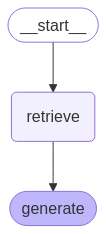

In [11]:

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))